In [10]:
import numpy as np
import pandas as pd
import pickle
import pickle as pk

import os,sys
import pylab as plt
import torch
import shutil, os, csv, itertools, glob

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import math
# model
cuda = torch.cuda.is_available()
class MLP(nn.Module):
    def __init__(self,in_dim, output_dim,hidden_dim=96):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(in_dim,hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim*2,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)
        
    def forward(self,din):
#         din = din.view(-1,28*28)
        dout = F.tanh(self.fc1(din))
#         dout = F.relu(self.fc2(dout))
        return self.fc3(dout)

def load_pickle(filename):
    try:
        p = open(filename, 'rb')
    except IOError:
        print("Pickle file cannot be opened.")
        return None
    try:
        picklelicious = pk.load(p)
    except ValueError:
        print('load_pickle failed once, trying again')
        p.close()
        p = open(filename, 'rb')
        picklelicious = pk.load(p)

    p.close()
    return picklelicious
def save_pickle(data_object, filename):
    pickle_file = open(filename, 'wb')
    pk.dump(data_object, pickle_file)
    pickle_file.close()
def path_exist(path):
    if not os.path.exists(path):
        os.mkdir(path)
def get_best_checkpoint(model_path):
    return model_path+'/model_best.pth.tar'
def save_checkpoint(state, is_best, filename):
    model_path,_=os.path.split(filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, model_path+'/model_best.pth.tar')
def destroy_checkpoint(model_path):
    fs = sorted([f for f in os.listdir(model_path) if 'Epoch' in f], key=lambda k: int(k.split()[1]))
#     for f in os.listdir(model_path):
#         if 'Epoch' in f and f != fs:
#             os.remove(f) 
    try:
        for f in os.listdir(model_path):
            if 'Epoch' in f and str(f) != str(fs[-1]):
                os.remove(model_path+f)
        return True
    except:
        return False

In [11]:
class Load_Dataset(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, dataset):
        super(Load_Dataset, self).__init__()

        X_train = dataset["samples"]
        y_train = dataset["labels"]

        if len(X_train.shape) < 3:
            X_train = X_train.unsqueeze(2)

        if X_train.shape.index(min(X_train.shape)) != 1:  # make sure the Channels in second dim
            X_train = X_train.permute(0, 2, 1)

        if isinstance(X_train, np.ndarray):
            self.x_data = torch.from_numpy(X_train)
            self.y_data = torch.from_numpy(y_train).long()
        else:
            self.x_data = X_train
            self.y_data = y_train

        self.len = X_train.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index], self.x_data[index], self.x_data[index]

    def __len__(self):
        return self.len


def data_generator(data_path,batch_size=128):

    train_dataset = torch.load(os.path.join(data_path, "train.pt"))
    valid_dataset = torch.load(os.path.join(data_path, "val.pt"))
    test_dataset = torch.load(os.path.join(data_path, "test.pt"))

    train_dataset = Load_Dataset(train_dataset)
    valid_dataset = Load_Dataset(valid_dataset)
    test_dataset = Load_Dataset(test_dataset)
    

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                               shuffle=True, drop_last=False,
                                               num_workers=0)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size,
                                               shuffle=False, drop_last=False,
                                               num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                              shuffle=False, drop_last=False,
                                              num_workers=0)

    return train_loader, valid_loader, test_loader


In [12]:
HAR_path=f"./HAR"
epilepsy_path=f"./Epilepsy"

In [13]:
train_loader, valid_loader, test_loader=data_generator(epilepsy_path,128)

In [14]:
class my_encoder(nn.Module):
    def __init__(self,
                 sizeHidden=512,
                 normMode="layerNorm"):

        super(my_encoder, self).__init__()

        validModes = ["batchNorm", "instanceNorm", "ID", "layerNorm"]
        if normMode not in validModes:
            raise ValueError(f"Norm mode must be in {validModes}")

        if normMode == "instanceNorm":
            def normLayer(x): return nn.InstanceNorm1d(x, affine=True)
        elif normMode == "ID":
            normLayer = cpc_model.IDModule
        elif normMode == "layerNorm":
            normLayer = cpc_model.ChannelNorm
        else:
            normLayer = nn.BatchNorm1d

        self.dimEncoded = sizeHidden
        self.conv0 = nn.Conv1d(1, sizeHidden, 8, dilation=1, stride=2, padding=4)
        self.batchNorm0 = normLayer(sizeHidden)
        self.conv1 = nn.Conv1d(sizeHidden, sizeHidden, 4, dilation=1, stride=2, padding=2)
        self.batchNorm1 = normLayer(sizeHidden)
        self.conv2 = nn.Conv1d(sizeHidden, sizeHidden, 4, dilation=1, stride=2, padding=1)
        self.batchNorm2 = normLayer(sizeHidden)
        # self.conv3 = nn.Conv1d(sizeHidden, sizeHidden, 4, dilation=1, stride=2, padding=0)
        # self.batchNorm3 = normLayer(sizeHidden)
        self.DOWNSAMPLING = 160

    def getDimOutput(self):
        return self.conv3.out_channels

    def forward(self, x):
        x = F.relu(self.batchNorm0(self.conv0(x)))
        x = F.relu(self.batchNorm1(self.conv1(x)))
        x = F.relu(self.batchNorm2(self.conv2(x)))
        # x = F.relu(self.batchNorm3(self.conv3(x)))
#         x = F.relu(self.batchNorm4(self.conv4(x)))
        return x
import argparse
import cpc.criterion as cr
import cpc.model as cpc_model
import cpc.feature_loader as fl
prompt_seq=4
class union_model(torch.nn.Module):
    def __init__(self):
        super(union_model, self).__init__()
        #cpc for smoothness
        args = argparse.ArgumentParser().parse_args(args=[])
        hidden=64
        args.hiddenEncoder=hidden
        args.outputdim=hidden
        args.hiddenGar=hidden
        args.arMode='transformer'
        args.samplingType= None #'sequential'
        args.cpc_mode="sequential" #'reverse'
        args.nLevelsGRU=3
        args.sizeWindow=160 * (23+prompt_seq) #for transformer
        args.abspos=True
        args.negativeSamplingExt=32  #model setting
        cpc_encoder=my_encoder(args.hiddenEncoder,"batchNorm")
        cpc_ar=fl.getAR(args)
        self.cpc_model=cpc_model.CPCModel_Promote_multi_seq_t(cpc_encoder,cpc_ar,hidden_dim=hidden,prompt_seq=prompt_seq)
        
        
        self.cpc_criterion=cr.CPCUnsupersivedCriterion(9,   # Number of steps
                         args.hiddenGar,           # Dimension of G_ar
                         args.outputdim,      # Dimension of the convolutional net
                         args.negativeSamplingExt,   # Number of negative samples to draw
                         mode=None,
                         rnnMode='lstm',
                         dropout=False,
                         speakerEmbedding=0,
                         nSpeakers=0,
                         sizeInputSeq=20) #for transformer
        for param in self.cpc_model.parameters():
            param.requires_grad = True
        self.cpc_model.eval()
        self.cpc_criterion.eval()
    def forward(self,x,label):
        representation,c_feature, encoded_data, label = self.cpc_model(x,label)
        cpc_loss,cpc_ac= self.cpc_criterion(c_feature, encoded_data, label)
        cpc_loss=cpc_loss.sum()
        cpc_ac=cpc_ac.mean()
        return representation,c_feature,encoded_data,cpc_loss,cpc_ac

In [15]:
def train(epoch,model,train_data_loader,optimizer,scheduler,criterion=nn.MSELoss()):
    model.train()
    train_loss = 0.
    accuracy=[]
    print_time=int(len(train_data_loader)/3)+1
    for batch_idx, (data, target,_,_) in enumerate(train_data_loader):
        data = data.float()
        if cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        representation,c_feature,encoded_data,loss,cpc_ac = model(data,target)
        train_loss+=loss.data.item()
        accuracy.append(cpc_ac.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch_idx % print_time == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Acc: {:.2f}%/{:.2f}%'.format(
                epoch, batch_idx, len(train_data_loader),
                100. * batch_idx / len(train_data_loader), loss.data.item(),
                100. *cpc_ac.item(),100. * np.mean(accuracy)))
    train_loss=train_loss/len(train_data_loader)
    print('Train set: Average loss: {:.4f} Acc:{:.2f}%'.format(
        train_loss, 100.* np.mean(accuracy)))
    return train_loss,np.mean(accuracy)
def test(model,valid_data_loader,criterion=nn.MSELoss()):
    model.eval()
    test_loss = 0.
    preds = []
    ar_preds = []
    r_preds = []
    accuracy=[]
    for (data, target,_,_) in valid_data_loader:
        data = data.float()
        if cuda:
            data, target = data.cuda(), target.cuda()
        representation,c_feature,encoded_data,loss,cpc_ac = model(data,target)
        test_loss += loss.data.item() # sum up batch loss
        preds.append(encoded_data.detach().cpu().numpy())
        ar_preds.append(c_feature.detach().cpu().numpy())
        r_preds.append(representation.detach().cpu().numpy())
        accuracy.append(cpc_ac.item())
    test_loss=test_loss/len(valid_data_loader)
    print('Test set: Average loss: {:.4f}, Accuracy:({:.2f}%)'.format(
        test_loss, 100. * np.mean(accuracy)))
#     return np.concatenate(preds,axis=0), test_loss,np.mean(accuracy)
    return preds,ar_preds,r_preds, test_loss,np.mean(accuracy)

def experiment(num_epoch=5,lr=0.001,resume=True):
    global train_loader,test_loader,model_path,model
    
    start_epoch = 0
    best_res = 1e9
    losscurve = []
    accurve = []
                  
    resume_state = get_best_checkpoint(model_path) if resume else None
    if resume_state and os.path.isfile(resume_state):
        print("=> loading checkpoint '{}'".format(resume_state))
        checkpoint = torch.load(resume_state,map_location={'cuda:0':'cuda:8'})
        start_epoch = checkpoint['epoch']+1
        best_res = checkpoint['best_res']
        losscurve = checkpoint['losscurve']
        accurve = checkpoint['accurve']
        model.load_state_dict(checkpoint['state_dict'])
        if cuda:
            model.cuda()
        optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=0.0005)
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler = checkpoint['scheduler']
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(resume_state, checkpoint['epoch']))
    else:
        if cuda:
            model.cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)
        scheduler = lr_scheduler.CyclicLR(optimizer, lr / 10, lr*2, step_size_up=10, step_size_down=10,
                                       cycle_momentum=False, mode="triangular")
    
    
    for epoch in range(start_epoch,start_epoch+num_epoch):
        is_best = False
        train_loss,train_ac = train(epoch,model,train_loader,optimizer,scheduler)
        _,_,_, val_loss,val_ac = test(model,valid_loader)
        losscurve.append((train_loss, val_loss))
        accurve.append((train_ac,val_ac))
        if val_loss < best_res:
            best_res = val_loss
            is_best = True
            save_checkpoint({
                    'epoch': epoch,
        #                 'arch': model.arch,
                    'state_dict': model.cpu().state_dict(),
                    'train_loss':train_loss,
                    'val_loss': val_loss,
                    'best_res':best_res,
                    'optimizer' : optimizer.state_dict(),
                    'scheduler' : scheduler,
                    'losscurve':losscurve,
                    'accurve':accurve,
                }, is_best,
                model_path+"Epoch %d Acc %.4f.pt"%(epoch, val_loss))
        if cuda:
            model.cuda()
    return losscurve,accurve

In [16]:
model_path="./model/cpc_open_ep_mp/"
torch.cuda.set_device(1)
model = union_model()

 Train Epoch: 0 [0/58 (0%)]	Loss: 31.479317 Acc: 1.89%/1.89%
 Train Epoch: 0 [20/58 (34%)]	Loss: 28.809441 Acc: 18.11%/12.83%
 Train Epoch: 0 [40/58 (69%)]	Loss: 25.136044 Acc: 27.98%/18.21%
Train set: Average loss: 27.1416 Acc:22.06%
Test set: Average loss: 25.4816, Accuracy:(19.73%)
 Train Epoch: 1 [0/58 (0%)]	Loss: 21.841122 Acc: 34.96%/34.96%
 Train Epoch: 1 [20/58 (34%)]	Loss: 19.064388 Acc: 40.21%/37.09%
 Train Epoch: 1 [40/58 (69%)]	Loss: 17.049513 Acc: 43.86%/39.39%
Train set: Average loss: 18.6094 Acc:41.01%
Test set: Average loss: 17.1143, Accuracy:(36.75%)
 Train Epoch: 2 [0/58 (0%)]	Loss: 15.876209 Acc: 45.03%/45.03%
 Train Epoch: 2 [20/58 (34%)]	Loss: 14.250486 Acc: 48.74%/47.44%
 Train Epoch: 2 [40/58 (69%)]	Loss: 12.961165 Acc: 50.95%/48.65%
Train set: Average loss: 13.9252 Acc:49.32%
Test set: Average loss: 13.5998, Accuracy:(46.49%)
 Train Epoch: 3 [0/58 (0%)]	Loss: 12.118353 Acc: 51.32%/51.32%
 Train Epoch: 3 [20/58 (34%)]	Loss: 11.318319 Acc: 51.33%/51.64%
 Train Epo

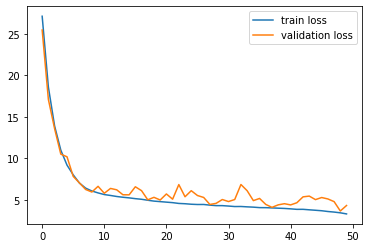

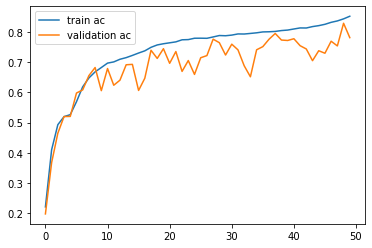

In [17]:
path_exist(model_path)
losscurve,accurve=experiment(50,resume=True)
plt.plot([i[0] for i in losscurve],label="train loss")
plt.plot([i[1] for i in losscurve],label="validation loss")
plt.legend()
plt.show()
plt.plot([i[0] for i in accurve],label="train ac")
plt.plot([i[1] for i in accurve],label="validation ac")
plt.legend()
plt.show()

In [18]:
def train(epoch,model,train_data_loader,optimizer,scheduler,
          criterion=nn.MSELoss(),topk_num=2):
    model.train()
    train_loss = 0.
    accuracy=[]
    print_time=int(len(train_data_loader)/3)+1
    for batch_idx, (data, target,_,_) in enumerate(train_data_loader):
        data, target = data.float(), target.float()
        if cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        represent,c_feature,encoded_data,loss,cpc_ac = model(data,target)
        train_loss+=loss.data.item()
        cpc_loss=loss.data.item()
        accuracy.append(cpc_ac.item())
        batch_size=represent.size()[0]
        # feature_size=represent.size()[-1]
        inner_coding=represent.clone()
        represent=represent.reshape((batch_size,-1))
        represent=represent-represent.min(dim=0,keepdims=True)[0]
        represent=represent/(represent.abs().max(dim=0,keepdims=True)[0]+1e-4)
        r_loss=(represent.unsqueeze(1)-represent.unsqueeze(0)).abs().topk(topk_num*4,
                                                                          largest=True,dim=-1)[0].mean()
        
        inner_coding=F.softmax(inner_coding,dim=-2).permute(0,2,1)
        inner_coding=torch.minimum(inner_coding,torch.tensor(0.95).cuda())
        inner_coding=torch.maximum(inner_coding,torch.tensor(0.05).cuda())
        c_loss=F.kl_div(inner_coding.unsqueeze(1).repeat([1,batch_size,1,1]).log(),
                        inner_coding.unsqueeze(0).repeat([batch_size,1,1,1]),reduction='none')
        c_loss=c_loss.sum(dim=-1).max(dim=-1)[0]
        c_loss=c_loss.mean()
        loss=loss-r_loss-c_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch_idx % print_time == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} rLoss: {:.6f} cLoss: {:.6f} Acc: {:.2f}%/{:.2f}%'.format(
                epoch, batch_idx, len(train_data_loader),
                100. * batch_idx / len(train_data_loader), cpc_loss,
                r_loss.data.item(),c_loss.data.item(),
                100. *cpc_ac.item(),100. * np.mean(accuracy)))
    train_loss=train_loss/len(train_data_loader)
    print('Train set: Average loss: {:.4f} Acc:{:.2f}%'.format(
        train_loss, 100.* np.mean(accuracy)))
    return train_loss,np.mean(accuracy)
def experiment(num_epoch=5,lr=0.001,resume=True):
    global train_loader,test_loader,model_path,model
    
    start_epoch = 0
    best_res = 1e9
    losscurve = []
    accurve = []
                  
    resume_state = get_best_checkpoint(model_path) if resume else None
    optimizer = torch.optim.Adam([{'params': model.cpc_model.prompt},
                                  {'params': model.cpc_model.projection.parameters()},
                                  {'params': model.cpc_model.gAR.parameters(), 'lr': 1e-4},
                                  {'params': model.cpc_model.gEncoder.parameters(), 'lr': 1e-4},
                                  {'params': model.cpc_criterion.parameters(), 'lr': 1e-4}
                                 ],
                                 lr=lr, weight_decay=0.0005)
    if resume_state and os.path.isfile(resume_state):
        print("=> loading checkpoint '{}'".format(resume_state))
        checkpoint = torch.load(resume_state,map_location={'cuda:0':'cuda:8'})
        start_epoch = checkpoint['epoch']+1
        best_res = checkpoint['best_res']
        losscurve = checkpoint['losscurve']
        accurve = checkpoint['accurve']
        model.load_state_dict(checkpoint['state_dict'])
        if cuda:
            model.cuda()
        scheduler = checkpoint['scheduler']
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(resume_state, checkpoint['epoch']))
    else:
        if cuda:
            model.cuda()
        scheduler = lr_scheduler.CyclicLR(optimizer, lr / 10, lr*2, step_size_up=10, step_size_down=10,
                                       cycle_momentum=False, mode="triangular")
    
    
    for epoch in range(start_epoch,start_epoch+num_epoch):
        is_best = False
        train_loss,train_ac = train(epoch,model,train_loader,optimizer,scheduler)
        _,_,_, val_loss,val_ac = test(model,valid_loader)
        losscurve.append((train_loss, val_loss))
        accurve.append((train_ac,val_ac))
        if cuda:
            model.cuda()
    return losscurve,accurve

=> loading checkpoint './model/cpc_open_ep_mp//model_best.pth.tar'
=> loaded checkpoint './model/cpc_open_ep_mp//model_best.pth.tar' (epoch 48)
 Train Epoch: 49 [0/58 (0%)]	Loss: 3.375048 rLoss: 0.635301 cLoss: 0.343492 Acc: 85.24%/85.24%
 Train Epoch: 49 [20/58 (34%)]	Loss: 3.367666 rLoss: 0.669640 cLoss: 1.477488 Acc: 85.27%/85.50%
 Train Epoch: 49 [40/58 (69%)]	Loss: 3.184245 rLoss: 0.706710 cLoss: 1.881430 Acc: 85.48%/85.63%
Train set: Average loss: 3.2729 Acc:85.59%
Test set: Average loss: 3.3734, Accuracy:(84.91%)
 Train Epoch: 50 [0/58 (0%)]	Loss: 3.493056 rLoss: 0.688664 cLoss: 2.117287 Acc: 84.15%/84.15%
 Train Epoch: 50 [20/58 (34%)]	Loss: 3.293693 rLoss: 0.724011 cLoss: 2.273976 Acc: 85.53%/85.87%
 Train Epoch: 50 [40/58 (69%)]	Loss: 3.442410 rLoss: 0.714485 cLoss: 2.315741 Acc: 84.70%/85.80%
Train set: Average loss: 3.2494 Acc:85.75%
Test set: Average loss: 3.3477, Accuracy:(85.11%)
 Train Epoch: 51 [0/58 (0%)]	Loss: 3.104356 rLoss: 0.735048 cLoss: 2.409502 Acc: 86.86%/86.8

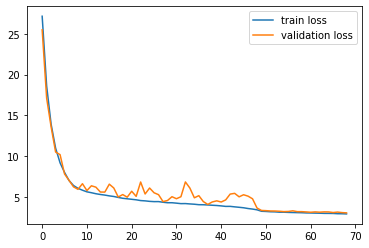

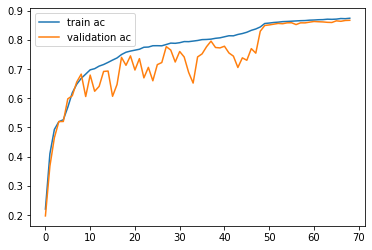

In [19]:
model = union_model()
path_exist(model_path)
losscurve,accurve=experiment(20,lr=0.001,resume=True)
plt.plot([i[0] for i in losscurve],label="train loss")
plt.plot([i[1] for i in losscurve],label="validation loss")
plt.legend()
plt.show()
plt.plot([i[0] for i in accurve],label="train ac")
plt.plot([i[1] for i in accurve],label="validation ac")
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix

def train_Dis(data_loader,epoch,pri=True,detail=False,edge_weight=None):
    model_Dis.train()
    sum_loss=0
    acc_counts=0
    counts=0
    for batch_idx, (data, target,_,_) in enumerate(data_loader):
        data=data.float()
        target=target.long()
        if cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        pred = model_Dis(data,target)
        loss = F.cross_entropy(pred, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        sum_loss+=loss.data.item()
        acc_counts+=pred.max(dim=-1)[1].eq(target).sum().data.item()
        counts+=len(target)
    if pri:
        print('Train Epoch: {}  mean Loss: {:.6f} mean ac: {:.6f}'.format(
                epoch, sum_loss/len(data_loader),acc_counts/counts))   
    return sum_loss/len(data_loader),acc_counts/counts
def test_Dis(data_loader,pri=True,detail=False,edge_weight=None,test=False):
    model_Dis.eval()
    test_loss=0.
    preds = []
    acc_counts=0
    counts=0
    test_score=[]
    conf_matrix_l=[]
    for batch_idx, (data, target,_,_) in enumerate(data_loader):
        data=data.float()
        target=target.long()
        if cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        pred = model_Dis(data,target)
        loss = F.cross_entropy(pred, target)
        test_loss+=loss.data.item()
        preds.append(pred.cpu().detach().numpy())
        acc_counts+=pred.max(dim=-1)[1].eq(target).sum().data.item()
        counts+=len(target)
        if detail:
            print(np.concatenate([pred.cpu().detach().numpy(),target.cpu().numpy()],axis=-1))
        if test:
            pred=pred.argmax(dim=-1).cpu().detach().numpy()
            sklearn_precision = precision_score(pred, target.cpu().numpy(), average='macro')
            sklearn_recall = recall_score(pred, target.cpu().numpy(), average='macro')
            sklearn_f1 = f1_score(pred, target.cpu().numpy(), average='macro')
            test_score.append([sklearn_precision,sklearn_recall,sklearn_f1])
            conf_matrix = confusion_matrix(pred, target.cpu().numpy(),labels=list(range(2)))
            conf_matrix_l.append(conf_matrix)
    test_loss /= len(data_loader)
    if pri:
        print('Test set: Average recon loss: {:.4f} mean ac: {:.6f}'.format(test_loss,acc_counts/counts))
    if test:
        print(np.mean(test_score,axis=0))
        print(np.sum(conf_matrix_l,axis=0))
    return preds,test_loss,acc_counts/counts
def exp(epochs=50,pri=True,detail=False):
    train_loss_curve=[]
    val_loss_curve=[]
    test_loss_curve=[]
    train_acc_curve=[]
    val_acc_curve=[]
    test_acc_curve=[]
    bst_loss=1e-4
    for epoch in range(epochs):
        train_loss,train_acc=train_Dis(train_loader,epoch=epoch,pri=pri,detail=detail)
        _,val_loss,val_acc=test_Dis(valid_loader,pri=pri)
        _,test_loss,test_acc=test_Dis(test_loader,pri=pri)
        train_loss_curve.append(train_loss)
        val_loss_curve.append(val_loss)
        test_loss_curve.append(test_loss)
        train_acc_curve.append(train_acc)
        val_acc_curve.append(val_acc)
        test_acc_curve.append(test_acc)
        if val_acc>bst_loss:
            bst_loss=val_acc
            torch.save(model_Dis.state_dict(), model_path+"dis_model")
    model_Dis.load_state_dict(torch.load(model_path+"dis_model"))
    #only print once
    test_Dis(test_loader,pri=pri,test=True)
    return train_loss_curve,val_loss_curve,test_loss_curve,train_acc_curve,val_acc_curve,test_acc_curve,bst_loss

In [21]:
class dis_model(torch.nn.Module):
    def __init__(self,union_model,hidden=64,class_num=2):
        super(dis_model, self).__init__()
        self.cpc_model=union_model.cpc_model
        self.final=nn.Linear(hidden*4,class_num)
        for param in self.cpc_model.parameters():
            param.requires_grad = False
    def forward(self,x,label):
        batch=x.shape[0]
        represent,c_feature, encoded_data, label = self.cpc_model(x,label)
        represent=represent.reshape((batch,-1))
        x=represent
        x=self.final(x)
        return x

Train Epoch: 0  mean Loss: 0.214168 mean ac: 0.914402
Test set: Average recon loss: 0.1277 mean ac: 0.952717
Test set: Average recon loss: 0.1252 mean ac: 0.958261
Train Epoch: 1  mean Loss: 0.144935 mean ac: 0.946603
Test set: Average recon loss: 0.1158 mean ac: 0.957609
Test set: Average recon loss: 0.1116 mean ac: 0.965652
Train Epoch: 2  mean Loss: 0.135393 mean ac: 0.951495
Test set: Average recon loss: 0.1075 mean ac: 0.956522
Test set: Average recon loss: 0.1062 mean ac: 0.965652
Train Epoch: 3  mean Loss: 0.134489 mean ac: 0.951630
Test set: Average recon loss: 0.1087 mean ac: 0.960326
Test set: Average recon loss: 0.1066 mean ac: 0.963478
Train Epoch: 4  mean Loss: 0.137229 mean ac: 0.950272
Test set: Average recon loss: 0.1030 mean ac: 0.958696
Test set: Average recon loss: 0.1024 mean ac: 0.964783
Train Epoch: 5  mean Loss: 0.129100 mean ac: 0.954076
Test set: Average recon loss: 0.1011 mean ac: 0.960326
Test set: Average recon loss: 0.1008 mean ac: 0.964348
Train Epoch: 6  

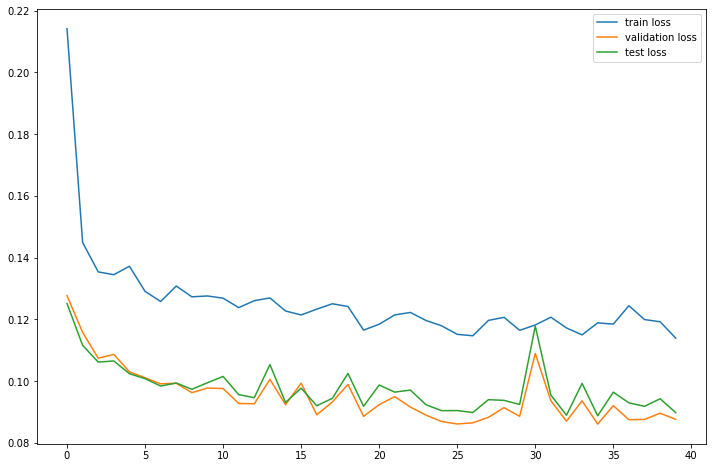

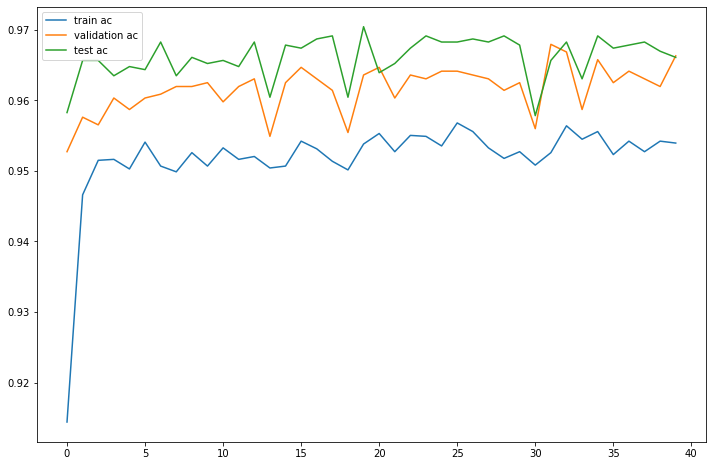

0.9679347826086957


In [22]:
model_Dis=dis_model(model,64,2).cuda()
lr=1e-3
optimizer = torch.optim.Adam(model_Dis.final.parameters(), lr=lr, weight_decay=0.0005)
scheduler = lr_scheduler.CyclicLR(optimizer, lr / 10, lr*2, step_size_up=10, step_size_down=10,
                                       cycle_momentum=False, mode="triangular")
train_loss_curve,val_loss_curve,test_loss_curve,train_acc_curve,val_acc_curve,test_acc_curve,bst_loss=exp(40)
plt.figure(figsize=(12,8))
plt.plot(train_loss_curve,label="train loss")
plt.plot(val_loss_curve,label="validation loss")
plt.plot(test_loss_curve,label="test loss")
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.plot(train_acc_curve,label="train ac")
plt.plot(val_acc_curve,label="validation ac")
plt.plot(test_acc_curve,label="test ac")
plt.legend()
plt.show()
print(bst_loss)